In [6]:
"""
Run Parameters

use_dataset: which dataset to run examples for {either H36m or 3DHP}
example: which example to use (int [0,5)
"""

use_dataset ='H36m'
# use_dataset ='3DHP'

example = 0

In [15]:
use_dataset = '3DHP'
example = 4


from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pickle
import os

from model import LinearModel, weight_init

import dataset_h36m
from dataset_h36m import H36MDataset
import dataset_3dhp
from dataset_3dhp import MpiInf3dDataset

import utils
from utils import batch_normalize_canon_pcl_human_joints, batch_normalize_canon_human_joints, denorm_human_joints

import pcl
import pcl_util

import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pylab import *
from PIL import Image
import constants


In [16]:
"""Plotting Functions used in this script"""

def plotPerspectiveCrop(ax_img, i, positions, scales, width, height, Ks, position_py, scale_py, lwidth=5, c_persp="blue", c_affine = "red"):
    P_virt2orig, R_virt2orig, K_virt = pcl.pcl_transforms(positions, scales, Ks, focal_at_image_plane=True, slant_compensation=True)
    grid_sparse = pcl.perspective_grid(P_virt2orig, torch.tensor([256, 256]), torch.Size([3, 3]), transform_to_pytorch=True)

    # convert back from pytorch coordinates
    xv = (grid_sparse[i,:,:,0].numpy()+1)/2 * width
    yv = (grid_sparse[i,:,:,1].numpy()+1)/2 * height

    # plot grid (once horizontal, once vertical lines)
    ax_img.plot(xv,yv,'-',linewidth=lwidth,color=c_persp)
    ax_img.plot(xv.transpose(),yv.transpose(),'-',linewidth=lwidth,color=c_persp)

    # plot rectangular crop
    rect = matplotlib.patches.Rectangle(
        (width  * ((position_py[i,0]+1)/2-scale_py[i,0]/2), height * ((position_py[i,1]+1)/2-scale_py[i,1]/2)),
        scale_py[i,0] * width, scale_py[i,1] * height,
        linewidth=lwidth, linestyle='dashed', edgecolor=c_affine, facecolor='none')
    ax_img.add_patch(rect)
    
bones_h36m = [[0,1], [1, 15], [2,1], [3, 2], [4,3], [5,1], [6,5], [7,6], [8,14], [9,8], [10,9], [11, 14], [12, 11], [13,12], [14,14], [15,14], [16,1]]
def plot_3Dpose(ax, pose_3d_1, bones=bones_h36m, linewidth=5, alpha=0.95, colormap='gist_rainbow', autoAxisRange=True, flip_yz=True, change_view=True, isGT=False):
    cmap = plt.get_cmap(colormap)
    pose_3d = pose_3d_1.clone()
    pose_3d = np.reshape(pose_3d.numpy().transpose(), (3, -1))
    pose_3d[1,:] *= -1

    if flip_yz:
        X, Y, Z = np.squeeze(np.array(pose_3d[0, :])), np.squeeze(np.array(pose_3d[2, :])), np.squeeze(
            np.array(pose_3d[1, :]))
    else:
        X, Y, Z = np.squeeze(np.array(pose_3d[0, :])), np.squeeze(np.array(pose_3d[1, :])), np.squeeze(
            np.array(pose_3d[2, :]))
    XYZ = np.vstack([X, Y, Z])

    if change_view:
        ax.view_init(elev=0, azim=-90)
    cmap = plt.get_cmap(colormap)

    maximum = len(bones)

    if not isGT:
        for i, bone in enumerate(bones):
            colorIndex = cmap.N - cmap.N * i/float(maximum) # cmap.N - to start from back (nicer color)
            color = cmap(int(colorIndex))
            depth = max(XYZ[1, bone])
            zorder = -depth # otherwise bones with be ordered in the order of drawing or something even more weird...
            ax.plot(XYZ[0, bone], XYZ[1, bone], XYZ[2, bone], color=color, linewidth=linewidth, zorder=zorder,
                                alpha=alpha, solid_capstyle='round')
    else:
        for i, bone in enumerate(bones):
            depth = max(XYZ[1, bone])
            zorder = -depth # otherwise bones with be ordered in the order of drawing or something even more weird...
            ax.plot(XYZ[0, bone], XYZ[1, bone], XYZ[2, bone], color='black', linewidth=linewidth, zorder=zorder,
                                alpha=alpha, solid_capstyle='round')

    # maintain aspect ratio
    if autoAxisRange:
        max_range = np.array([X.max() - X.min(), Y.max() - Y.min(), Z.max() - Z.min()]).max() / 2.0

        mid_x = (X.max() + X.min()) * 0.5
        mid_y = (Y.max() + Y.min()) * 0.5
        mid_z = (Z.max() + Z.min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

def plot_qualitative_pose(ax, plot_image, canon_label_no_norm, factor=8, x_off=128, y_off=-128, z_off=-10000, colormap='gist_rainbow', linewidth=5, isGT=False, elev=10, azim=-90):
    if plot_image is not None:
        plot_3Dpose(ax, (canon_label_no_norm/factor)+torch.tensor([x_off, y_off, z_off]), flip_yz=True, autoAxisRange=False, colormap=colormap, linewidth=linewidth)
    else:
        if not isGT:
            plot_3Dpose(ax, canon_label_no_norm, flip_yz=True, autoAxisRange=True, colormap=colormap, linewidth=linewidth)
        else:
            plot_3Dpose(ax, canon_label_no_norm, flip_yz=True, autoAxisRange=False, colormap=colormap, isGT=isGT, linewidth=linewidth)
    if plot_image is not None:
        ax.plot_surface(x,y,z, rstride=1, cstride=1, facecolors=plot_image)
        ax.set_xlim(0, img.shape[0])
        ax.set_zlim(0,img.shape[1])
        ax.view_init(elev=10, azim=-90)

    plt.grid(True)

    plt.setp(ax.get_xticklabels(),visible=False)
    plt.setp(ax.get_yticklabels(),visible=False)
    plt.setp(ax.get_zticklabels(),visible=False)

In [17]:
"""
Code for preping input 2D poses to be handled by the network
PCL Preprocess: Converts the 2D poses to virtual camera coordinates and then normalizes them
PCL Postprocess: Converts the output (from the network) 3D poses from virtual camera to camera coordinates
"""

def pcl_preprocess(batch_size, num_joints, canon_label_2d_with_hip, orig_img_shape, Ks_px_orig, location, scale, \
    normalize=True, use_slant_compensation=False, use_dataset='H36m'):

    canon_virt_2d, R_virt2orig, P_virt2orig = pcl.pcl_transforms_2d(canon_label_2d_with_hip, location, scale, Ks_px_orig,\
                                                                    focal_at_image_plane=True, \
                                                                    slant_compensation=use_slant_compensation)
    model_input = canon_virt_2d.clone()
    
    if use_dataset == 'H36m':
        if normalize:
            if use_slant_compensation:
                model_input = utils.batch_normalize_canon_pcl_human_joints(model_input, constants.H36m_2d_PCL_Mean_2dScale, constants.H36m_2d_PCL_Std_2dScale)
            else:
                model_input = utils.batch_normalize_canon_pcl_human_joints(model_input, constants.H36m_2d_PCL_Mean, constants.H36m_2d_PCL_Std)
    else:
        if normalize:
            if use_slant_compensation:
                model_input = utils.batch_normalize_canon_pcl_human_joints(model_input, constants.mpi_2d_pcl_slant_mean, constants.mpi_2d_pcl_slant_std)
            else:
                model_input = utils.batch_normalize_canon_pcl_human_joints(model_input, constants.mpi_2d_pcl_3dscale_mean, constants.mpi_2d_pcl_3dscale_std)

    model_input = model_input.view(batch_size, -1)

    return {'model_input':model_input, 'canon_virt_2d':canon_virt_2d, 'R_virt2orig':R_virt2orig, 'P_virt2orig':P_virt2orig}

def pcl_postprocess(batch_size, num_joints, output, R_virt2orig, device='cpu', use_dataset='H36m'):
    if use_dataset == 'H36m':
        canonical_mean = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36mMean)
        canonical_std = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36mStd)
    else:
        canonical_mean = dataset_3dhp.mpi_3d_Mean
        canonical_std = dataset_3dhp.mpi_3d_Std

    R_virt2orig = R_virt2orig
    new_pre_transform = output.view(batch_size, num_joints, -1)
    new_pre_transform = denorm_human_joints(new_pre_transform, canonical_mean, canonical_std).unsqueeze(3)

    new_output = pcl.virtPose2CameraPose(new_pre_transform, R_virt2orig, batch_size, num_joints)

    normalized_output = batch_normalize_canon_human_joints(new_output, mean=canonical_mean, std=canonical_std)
    new_pre_transform = new_pre_transform.squeeze(-1).view(batch_size, num_joints, -1)

    new_pre_transform = batch_normalize_canon_human_joints(new_pre_transform, mean=canonical_mean, std=canonical_std)
    return {"pre_transform":new_pre_transform, "output":normalized_output, 'output_no_norm':new_output}

In [18]:
"""
Load and preprocess 2D pose and pass those inputs through two pretrained networks (one trained with PCL and 
one trained with rectangular crops). This script shows how to use the "PCL Preprocess" (converting from Camera 2D pose
to virtual camera 2D pose) and the "PCL Postprocess" (which converts predicted a 3D pose in virtual camera coordinates 
back to camera coordinates)
"""

pcl_output = None
stn_output = None

if use_dataset == 'H36m':
    with open('imgs/H36m-sample.pickle', 'rb') as f:
        test = pickle.load(f)
    data = test[example]
else:
    with open('imgs/3DHP-sample.pickle', 'rb') as f:
        test = pickle.load(f)
    data = test[example]

for i in range(2):
    """
    SELECT WHICH MODEL WILL BE LOADED
        - Note the model selected for H36m and 3DHP where trained with different parameters
          the H36m models were trained with knowledge of the 3D root while the 3DHP models
          were trained when only knowing the 2D scale.
    """
    use_pcl = i
    if use_dataset == 'H36m':
        if use_pcl:
            model_dir = 'demo_models/2D-3D/H36m/PCL-2DGT-3DRootGT'
        else:
            model_dir = 'demo_models/2D-3D/H36m/STN-2DGT-3DRootGT'
    else:
        if use_pcl:
            model_dir = 'demo_models/2D-3D/3DHP/PCL-2DGT-2DScale'
        else:
            model_dir = 'demo_models/2D-3D/3DHP/STN-2DGT-2DScale'

    """LOAD IN THE MODEL"""
    model = LinearModel()
    model_file = os.path.join(model_dir, "lowest_validation_model.tar")
    checkpoint = torch.load(model_file, map_location='cpu')
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    """READ IN DATA"""
    # Image Inputs
    img = data['img']
    
    # PCL Parameters
    Ks_px_orig = data['Ks_px']
    orig_img_shape = data['orig_img_shape']
    location_px = data['crop_location_px'].float()
    scale_px = data['crop_scale_px'].float()
    
    # Pose 3D
    label_3d = data['label_3d']
    
    # Pose 2D
    label_2d_px = data['label_2d_px'] # this includes the hip location and is NOT canonical pose (for H36m)

    """DATA PREPROCESSING FOR STN INPUT"""
    square_scale = torch.tensor([torch.max(scale_px.squeeze(0)), torch.max(scale_px.squeeze(0))])
    square_scale_py = square_scale / orig_img_shape.squeeze(0)

    scale_py = square_scale_py.unsqueeze(0)
    location_py = utils.pixel_2_pytorch_locations(location_px, orig_img_shape[:,0], orig_img_shape[:,1])

    if use_dataset == "H36m":
        hips = label_2d_px[:,0,:].unsqueeze(1).repeat(1,label_2d_px.shape[1],1)
    else:
        hips = hips = label_2d_px[:,14,:].unsqueeze(1).repeat(1,label_2d_px.shape[1],1)

    label_2d_no_hip = label_2d_px - hips
    
    
    """ENSURE THAT ALL INPUTS AND LABELS ARE IN CANONICAL FORM"""
    if use_dataset == 'H36m':
        label_2d_px = dataset_h36m.h36m_to_canonical_skeleton(label_2d_px)
        canon_label_2d = dataset_h36m.h36m_to_canonical_skeleton(label_2d_no_hip)
        label_3d = dataset_h36m.h36m_to_canonical_skeleton(label_3d)
    else:
        canon_label_2d = label_2d_no_hip

    num_joints = label_2d_px.shape[1] # computes the number of joints in the pose
    bs = label_2d_px.shape[0] # computes the batch size of the input

    """PROCESSING THE INPUTS FOR PCL"""
    if use_pcl:
        if use_dataset == 'H36m':
            preprocess = pcl_preprocess(bs, num_joints, label_2d_px, orig_img_shape, Ks_px_orig, \
                                        location_px, scale_px, normalize=True, \
                                        use_slant_compensation=False, use_dataset=use_dataset)

            model_input = preprocess['model_input']
            canon_virt_2d = preprocess['canon_virt_2d']
            R_virt2orig = preprocess['R_virt2orig']

        else:
            preprocess = pcl_preprocess(bs, num_joints, label_2d_px, orig_img_shape, Ks_px_orig, \
                                        location_px, scale_px, normalize=True, \
                                        use_slant_compensation=True, use_dataset=use_dataset)
            model_input = preprocess['model_input']
            canon_virt_2d = preprocess['canon_virt_2d']
            R_virt2orig = preprocess['R_virt2orig']        
    else:
        # input is 2D Canonical Pose
        model_input = canon_label_2d.detach().clone()
        model_input = model_input / scale_py.unsqueeze(1)

        if use_dataset == 'H36m':
            mean = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36m_2d_Mean)
            std = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36m_2d_Std)
        else:
            mean = dataset_3dhp.mpi_2d_stn_slant_mean
            std = dataset_3dhp.mpi_2d_stn_slant_std
        model_input = batch_normalize_canon_human_joints(model_input, mean, std)

        model_input = model_input.view(bs, -1)

    """PASS THE INPUT 2D POSE TO THE MODEL WHICH PREDICTS A 3D POSE"""
    output = model(model_input)

    """USING THE PCL POSTPROCESS TO CONVERT PREDICTED 3D POSE FROM VIRTUAL CAMERA COORDINATES TO CAMERA COORDINATES"""
    if use_pcl:
        postprocess = pcl_postprocess(bs, num_joints, output, R_virt2orig, 'cpu', use_dataset=use_dataset)
        output = postprocess['output_no_norm']
        normalized_output = postprocess['output']
        pre_transform = postprocess['pre_transform']
    else: 
        output = output.view(bs, -1, 3)
        if use_dataset == 'H36m':
            canonical_mean = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36mMean)
            canonical_std = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36mStd)
        else:
            canonical_mean = dataset_3dhp.mpi_3d_Mean
            canonical_std = dataset_3dhp.mpi_3d_Std
        output = denorm_human_joints(output, canonical_mean, canonical_std)

    """STORE PREDICTED POSES FOR PLOTTING LATER ON"""
    if use_pcl:
        pcl_output = output.detach().clone()
    else:
        stn_output = output.detach().clone()

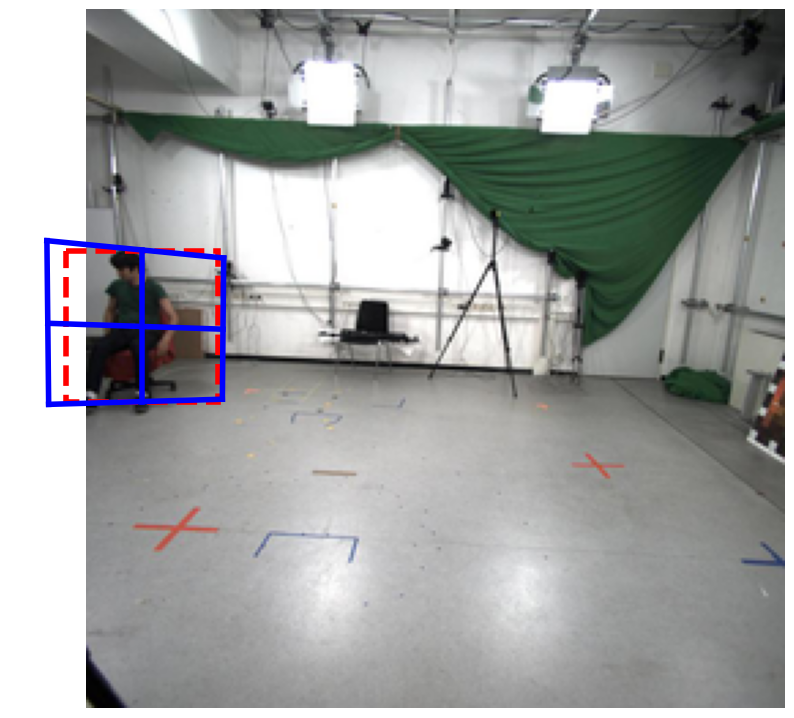

In [19]:
"""
PCL AND RECTANGULAR CROP VISUALIZATION
Similar to the pcl_demo.ipynb script, we visualize the PCL and rectangualr crop on the original image
"""
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
input_img = Image.fromarray((img.squeeze(0).permute(1,2,0).numpy()*255).astype(uint8))
ax.imshow(input_img)
img_w_h_shape = torch.tensor([256, 256])
use_location = location_px / orig_img_shape * img_w_h_shape.unsqueeze(0)
use_scale = scale_px / orig_img_shape * img_w_h_shape
Ks = pcl_util.K_new_resolution_px(Ks_px_orig, orig_img_shape, img_w_h_shape)
plotPerspectiveCrop(ax, 0, use_location, use_scale, 256, 256, Ks, location_py, scale_py, lwidth=4)
ax.axis('off')
plt.show()

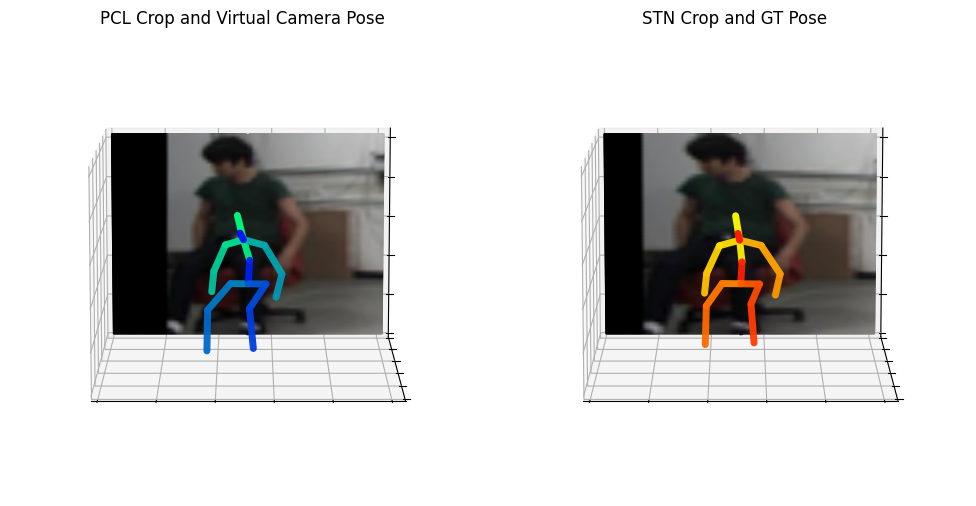

In [20]:
"""
VISUALIZING THE 3D POSES AGAINST THE RESPECTIVE CROPS
Here we can see that the predicted virtual camera pose lines up better with the PCL crop image than the pose predicted
with root centering and the rectangular crop.
"""

P_virt2orig, R_virt2orig, K_virt = pcl.pcl_transforms(use_location, use_scale, Ks, focal_at_image_plane=True, slant_compensation=True)
grid_perspective = pcl.perspective_grid(P_virt2orig, img_w_h_shape,\
        (img_w_h_shape), transform_to_pytorch=True)
grid_sparse = pcl.perspective_grid(P_virt2orig, img_w_h_shape,\
        torch.tensor([3, 3]), transform_to_pytorch=True)

affine_matrix = torch.zeros([1,2,3])
affine_matrix[:,0,0] = square_scale_py[0]
affine_matrix[:,1,1] = square_scale_py[1]
affine_matrix[:,:2,2] = location_py

affine_grid = F.affine_grid(affine_matrix, img.size(), align_corners=False)

pcl_crop = F.grid_sample(img.clone(), grid_perspective, align_corners=False)
stn_crop = F.grid_sample(img.clone(), affine_grid, align_corners=False)

if use_dataset == 'H36m':
    canonical_mean = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36mMean)
    canonical_std = dataset_h36m.h36m_to_canonical_skeleton(dataset_h36m.H36mStd)
else:
    canonical_mean = dataset_3dhp.mpi_3d_Mean
    canonical_std = dataset_3dhp.mpi_3d_Std
    
denorm_pre_transform = denorm_human_joints(pre_transform, canonical_mean, canonical_std).detach()

img = pcl_crop.detach().cpu().squeeze(0).permute(1,2,0)
z,x= ogrid[0:img.shape[0], 0:img.shape[1]]
y = np.atleast_2d(50)
im = Image.fromarray((img.numpy()*255).astype(np.uint8))
image = im.transpose(Image.FLIP_TOP_BOTTOM)
image.save('imgs/dummy.png', format='png')
plot_image = plt.imread('imgs/dummy.png')

img = stn_crop.detach().cpu().squeeze(0).permute(1,2,0)
z,x= ogrid[0:img.shape[0], 0:img.shape[1]]
y = np.atleast_2d(50)
im = Image.fromarray((img.numpy()*255).astype(np.uint8))
image = im.transpose(Image.FLIP_TOP_BOTTOM)
image.save('imgs/dummy.png', format='png')
plot_image_stn = plt.imread('imgs/dummy.png')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
plot_qualitative_pose(ax, plot_image, denorm_pre_transform, factor=8, x_off=128, y_off=-128, z_off=-10000, colormap='winter')
ax.set_title("PCL Crop and Virtual Camera Pose")
plt.margins(0,0,0)
ax1 = fig.add_subplot(122, projection='3d')
plot_qualitative_pose(ax1, plot_image_stn, stn_output.clone(), factor=8, x_off=128, y_off=-128, z_off=-10000, colormap='autumn')
ax1.set_title("STN Crop and GT Pose")
plt.margins(0,0,0)
fig.tight_layout()

plt.show()

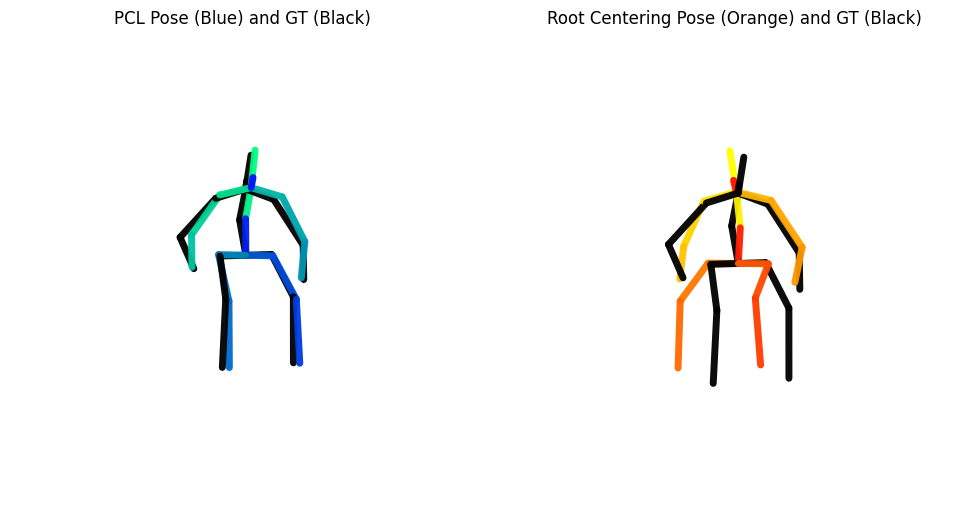

In [21]:
"""
VISUALIZING PREDICTED PCL POSE AND ROOT CENTERED POSE AGAINST GT LABEL
Here we can see that the PCL predicted pose is better aligned with the GT label than the root-centered predicted pose
# """
gt = label_3d

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
plot_qualitative_pose(ax, None, gt.detach(), factor=8, x_off=128, y_off=-128, z_off=-10000, colormap='Greys', isGT=True, linewidth=5)
plot_qualitative_pose(ax, None, pcl_output.detach(), factor=8, x_off=128, y_off=-128, z_off=-10000, colormap='winter',linewidth=5)
plt.axis("Off")
ax.set_title("PCL Pose (Blue) and GT (Black)")

ax1 = fig.add_subplot(122, projection='3d')
plot_qualitative_pose(ax1, None, gt.detach(), factor=8, x_off=128, y_off=-128, z_off=-10000, colormap='Greys', isGT=True, linewidth=5)
plot_qualitative_pose(ax1, None, stn_output.detach(), factor=8, x_off=128, y_off=-128, z_off=-10000, colormap='autumn',linewidth=5)
ax1.set_title("Root Centering Pose (Orange) and GT (Black)")
fig.tight_layout()
plt.margins(0,0,0)
plt.axis("Off")
plt.show()